<a href="https://colab.research.google.com/github/nab-18/BitPredictTimeSeries/blob/main/BitPredict_Milestone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-07-31 08:05:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2024-07-31 08:05:23 (17.7 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import minmax_scale

import tensorflow as tf
from tensorflow.keras import layers

## Import data

In [ ]:
data = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", parse_dates=['Date'],
                   index_col=['Date'])

In [ ]:
data.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
len(data)

2787

#### Reformat dataframe

In [ ]:
bitcoin_prices = pd.DataFrame(data['Closing Price (USD)'])
bitcoin_prices = bitcoin_prices.rename(columns={'Closing Price (USD)': 'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Text(0.5, 1.0, 'Price of bitcoin from 01/10/2013 to 18/05/2021')

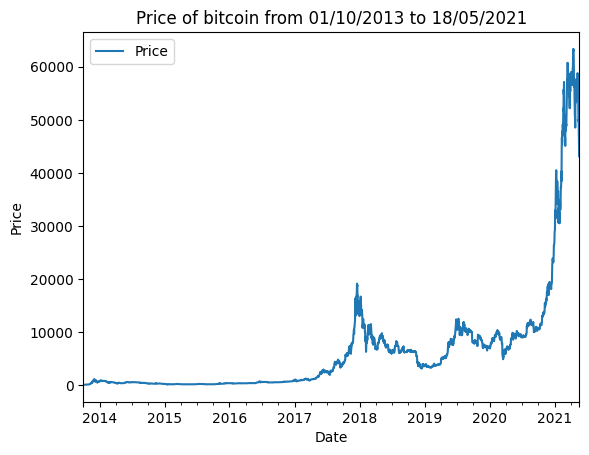

In [ ]:
bitcoin_prices.plot()
plt.ylabel('Price')
plt.title("Price of bitcoin from 01/10/2013 to 18/05/2021")

## Preprocessing

In [ ]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(timesteps, prices,
                                                    test_size=0.2,
                                                    shuffle=False,)

In [ ]:
# Create a plot function for time series

def plot_time_series(x, y, format='.', start=0, end=None, label=None):
  """
  Plots timesteps against values
  """
  plt.plot(x[start:end], y[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Price")
  plt.grid(True)

# Model Construction

## Model 0 | Baseline | Naive Model

$$\hat{y}_{t} = y_{t-1}$$ for horizon = 1

In [ ]:
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

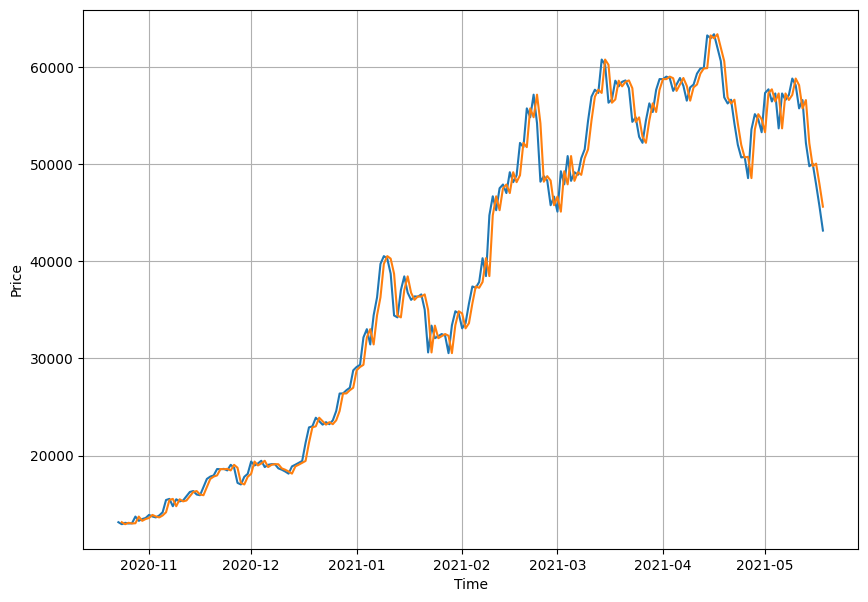

In [ ]:
plt.figure(figsize=(10,7))
# plot_time_series(X_train, y_train, start=300)
plot_time_series(X_test, y_test, start=350, format='-')

plot_time_series(X_test[1:], naive_forecast, start=350, format='-')

### Evaluate Model

#### Define evaluation functions

*Define MASE function*

In [ ]:
def mase(y_true, y_pred):
  """
  Implement MASE assuming no seasonality

  Args:
    y_true:
    y_pred:
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # Seasonality is 1 day -> 1 shift

  return mae / mae_naive_no_season

In [ ]:
mase(y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

*Create metrics dictionary function*

In [ ]:
def metrics_dict(y_true, y_pred):
  metric_dict = {'Mean Absolute Error': mean_absolute_error(y_true, y_pred),
          'Mean Absolute Percentage Error': mean_absolute_percentage_error(y_true, y_pred)*100,
          'MSE': mean_squared_error(y_true, y_pred),
          'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
          'MASE': mase(y_true, y_pred).numpy()}
  return metric_dict

In [ ]:
model_0_metrics = metrics_dict(y_test[1:], naive_forecast)
model_0_metrics

{'Mean Absolute Error': 567.9802273457542,
 'Mean Absolute Percentage Error': 2.516524929982267,
 'MSE': 1147547.125023896,
 'RMSE': 1071.2362601330744,
 'MASE': 0.9995699939182624}

### Windowing our dataset

Turn data into a supervised learning problem

We want to use 7 steps (a week) to predict the 8th day

In [ ]:
HORIZON = 1   # Predict next day
WINDOW_SIZE = 7   # Use the past week to make the prediction

In [ ]:
# Create function to label windowed data

def get_labelled_windows(x, horizon=HORIZON):
  """
  Create labels for windowed dataset
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  Args:
    x:
    horizon:
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]], dtype=int32)>)

#### Let's create a function to run this across the entire dataset

In [ ]:
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels
  Args:
    x:
    window_size:
    horizon:
  """
  # Create window and add horizon for labelling later
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # Create 2D array of multiple window steps
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T
  #print(window_indexes, window_indexes.shape)

  # Index on target array
  windowed_array = x[window_indexes]

  # Get labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices)

Split data (again)

In [ ]:
train_windows, test_windows, train_labels, test_labels = train_test_split(full_windows, full_labels, shuffle=False, test_size=0.2)

## Create a modelling checkpoint callback

In [ ]:
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

## Model 1 | Dense model | (window = 7, horizon = 1)

In [ ]:
# Build
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_1_dense')

# Compile
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='mae',
                metrics=['mae', 'mse'])

# Fit
history1 = model_1.fit(train_windows, train_labels,
                       validation_data=[test_windows, test_labels],
                       epochs=100,
                       batch_size=128,
                       callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 5s 113ms/step - loss: 1176.7103 - mae: 1176.7103 - mse: 5158373.0000 - val_loss: 3055.2334 - val_mae: 3055.2334 - val_mse: 20556122.0000
Epoch 2/100
18/18 [==============================] - 2s 113ms/step - loss: 341.2492 - mae: 341.2492 - mse: 455738.0625 - val_loss: 1358.7958 - val_mae: 1358.7958 - val_mse: 4707727.5000
Epoch 3/100
18/18 [==============================] - 1s 82ms/step - loss: 202.2102 - mae: 202.2102 - mse: 190968.2344 - val_loss: 1202.8563 - val_mae: 1202.8563 - val_mse: 3903860.5000
Epoch 4/100
18/18 [==============================] - 1s 81ms/step - loss: 172.2618 - mae: 172.2618 - mse: 155943.9219 - val_loss: 924.6229 - val_mae: 924.6229 - val_mse: 2854631.0000
Epoch 5/100
18/18 [==============================] - 1s 72ms/step - loss: 164.1248 - mae: 164.1248 - mse: 144799.7969 - val_loss: 921.7487 - val_mae: 921.7487 - val_mse: 2760821.5000
Epoch 6/100
18/18 [==============================] - 1s 87ms/step - loss:

In [ ]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("/content/model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 564.3345 - mae: 564.3345 - mse: 1157151.0000


[564.3345336914062, 564.3345336914062, 1157151.0]

#### Define a forecast function

In [ ]:
def make_preds(model, input_data):

  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

#### Predictions

In [ ]:
model_1_preds = make_preds(model_1, test_windows)
model_1_metrics = metrics_dict(test_labels, tf.cast(model_1_preds, dtype=tf.float64))
model_1_metrics

18/18 [==============================] - 0s 2ms/step


{'Mean Absolute Error': 564.3346098017358,
 'Mean Absolute Percentage Error': 2.528351635143704,
 'MSE': 1157151.4508582186,
 'RMSE': 1075.7097428480504,
 'MASE': 30.111794573692777}

#### Plot model 1 predictions

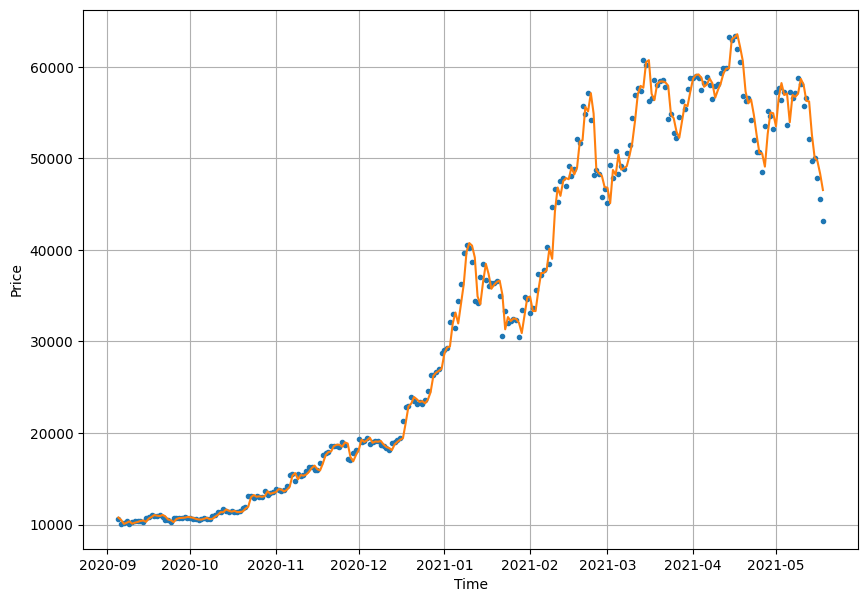

In [ ]:
offset=300
plt.figure(figsize=(10, 7))

plot_time_series(x=X_test[-len(test_windows):], y=test_labels[:, 0], start=offset, label="Test Data")

plot_time_series(x=X_test[-len(test_windows):], y=model_1_preds, start=offset, label="Test Data", format='-')

## Model 2 | Dense model | (window = 30, horizon = 1)

In [ ]:
# Set up horizon and window size
HORIZON = 1
WINDOW_SIZE = 30

# Create dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

# Split data
train_windows, test_windows, train_labels, test_labels = train_test_split(full_windows, full_labels, shuffle=False, test_size=0.2)

In [ ]:
# Build
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_2_dense')

# Compile
model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# Fit
history2 = model_2.fit(train_windows, train_labels,
                       validation_data=[test_windows, test_labels],
                       epochs=100,
                       batch_size=128,
                       callbacks=create_model_checkpoint(model_name=model_2.name))

Epoch 1/100
18/18 [==============================] - 2s 53ms/step - loss: 703.2445 - mae: 703.2445 - mse: 1940863.3750 - val_loss: 2319.5146 - val_mae: 2319.5146 - val_mse: 13436218.0000
Epoch 2/100
18/18 [==============================] - 1s 32ms/step - loss: 362.6367 - mae: 362.6367 - mse: 577968.4375 - val_loss: 1596.7113 - val_mae: 1596.7113 - val_mse: 6724601.0000
Epoch 3/100
18/18 [==============================] - 1s 31ms/step - loss: 225.6287 - mae: 225.6287 - mse: 244342.4219 - val_loss: 1111.2222 - val_mae: 1111.2222 - val_mse: 3771647.0000
Epoch 4/100
18/18 [==============================] - 1s 33ms/step - loss: 196.8226 - mae: 196.8226 - mse: 195441.1719 - val_loss: 1108.5819 - val_mae: 1108.5819 - val_mse: 4074163.0000
Epoch 5/100
18/18 [==============================] - 1s 34ms/step - loss: 203.8468 - mae: 203.8468 - mse: 196545.7344 - val_loss: 1025.7885 - val_mae: 1025.7885 - val_mse: 3257074.0000
Epoch 6/100
18/18 [==============================] - 1s 64ms/step - loss:

#### Predictions

In [ ]:
model_2 = tf.keras.models.load_model('/content/model_experiments/model_2_dense')
model_2_preds = model_2.predict(test_windows)

18/18 [==============================] - 0s 2ms/step


In [ ]:
model_2_metrics = metrics_dict(test_labels, model_2_preds)
model_2_metrics

{'Mean Absolute Error': 608.5477314066446,
 'Mean Absolute Percentage Error': 2.7530859617635093,
 'MSE': 1286435.9986967738,
 'RMSE': 1134.2116198914441,
 'MASE': 1.0637473169416323}

#### Plot model 2 predictions

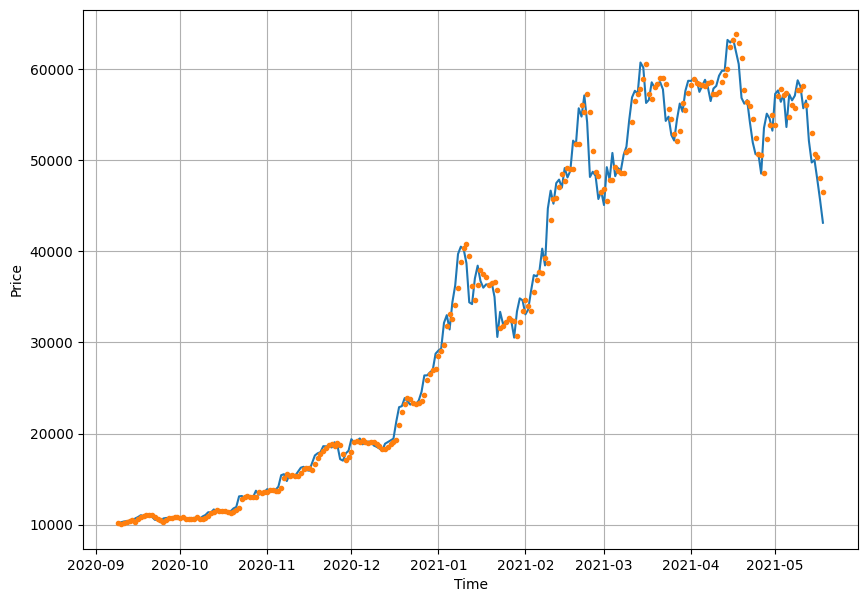

In [ ]:
# Plot
offset = 300
plt.figure(figsize=(10, 7))

plot_time_series(x=X_test[-len(test_windows):], y=test_labels[:, 0], start=offset, label="Test Data", format='-')
plot_time_series(x=X_test[-len(test_windows):], y=model_2_preds, start=offset, label="Test Data")

## Model 3 | Dense model | (horizon = 30, window = 7)

train_test_split won't work for horizons greater than 1. We need to define our own function.

In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
# Set up horizon and window size
HORIZON = 7
WINDOW_SIZE = 30

# Create dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

# Split dataset
train_windows, test_windows, train_labels, test_labels = train_test_split(full_windows, full_labels, test_size=0.2, shuffle=False)

In [ ]:
# Build
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_3_dense')

# Compile
model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# Fit
history3 = model_3.fit(train_windows, train_labels,
                       validation_data=[test_windows, test_labels],
                       epochs=100,
                       batch_size=128,
                       callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
18/18 [==============================] - 1s 44ms/step - loss: 1980.1168 - mae: 1980.1168 - mse: 16932590.0000 - val_loss: 3803.8960 - val_mae: 3803.8960 - val_mse: 42654876.0000
Epoch 2/100
18/18 [==============================] - 1s 32ms/step - loss: 546.3437 - mae: 546.3437 - mse: 1358577.2500 - val_loss: 2120.9160 - val_mae: 2120.9160 - val_mse: 13241179.0000
Epoch 3/100
18/18 [==============================] - 1s 32ms/step - loss: 410.1383 - mae: 410.1383 - mse: 808149.0625 - val_loss: 2116.3069 - val_mae: 2116.3069 - val_mse: 13268442.0000
Epoch 4/100
18/18 [==============================] - 0s 5ms/step - loss: 378.2889 - mae: 378.2889 - mse: 706826.5000 - val_loss: 2118.0974 - val_mae: 2118.0974 - val_mse: 12788365.0000
Epoch 5/100
18/18 [==============================] - 1s 32ms/step - loss: 354.1234 - mae: 354.1234 - mse: 611640.8125 - val_loss: 1763.9180 - val_mae: 1763.9180 - val_mse: 9652607.0000
Epoch 6/100
18/18 [==============================] - 1s 30ms/step -

#### Predictions

In [ ]:
model_3 = tf.keras.models.load_model("/content/model_experiments/model_3_dense")

model_3_preds = model_3.predict(test_windows)

18/18 [==============================] - 0s 2ms/step


In [ ]:
model_3_preds

array([[ 9435.252,  9239.86 ,  9466.193, ...,  9431.017,  9486.952,
         9529.583],
       [ 9013.704,  9021.747,  9071.351, ...,  9238.384,  9184.862,
         9192.257],
       [ 8892.526,  8946.386,  8862.099, ...,  9134.564,  9169.81 ,
         8972.164],
       ...,
       [57807.94 , 57660.594, 58724.26 , ..., 58115.45 , 58641.703,
        58512.28 ],
       [57906.37 , 58278.543, 58784.63 , ..., 58815.094, 59161.12 ,
        59412.53 ],
       [57454.19 , 57584.56 , 57579.16 , ..., 58550.688, 58798.105,
        58220.82 ]], dtype=float32)

In [ ]:
model_3_metrics = metrics_dict(test_labels, model_3_preds)
model_3_metrics

{'Mean Absolute Error': 1233.6023952086496,
 'Mean Absolute Percentage Error': 5.548340182692226,
 'MSE': 5411411.48551271,
 'RMSE': 2326.2440726442937,
 'MASE': 2.195126317266542}

#### Plot model 3 predictions

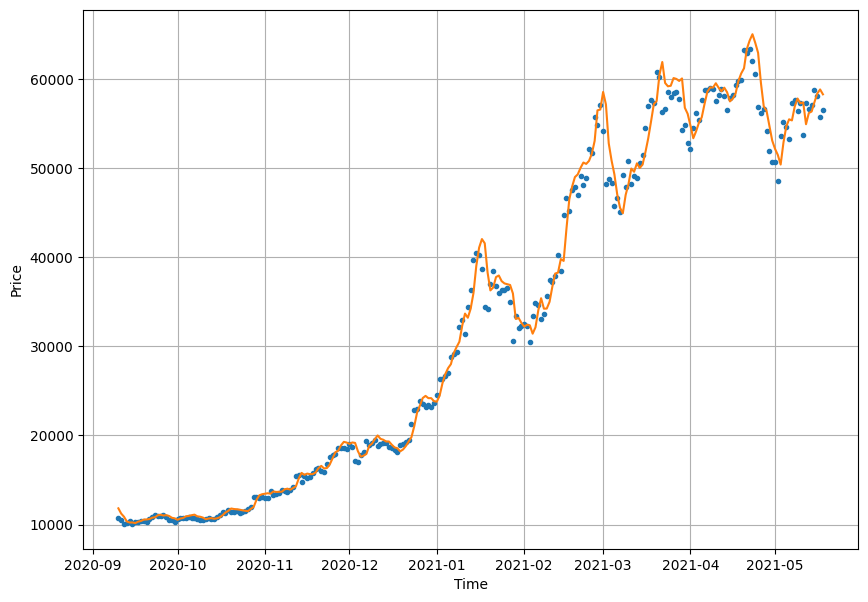

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))

plot_time_series(x=X_test[-len(test_windows):], y=test_labels[:, 0], start=offset, label="Test Data", format='.')
plot_time_series(x=X_test[-len(test_windows):], y=tf.reduce_mean(model_3_preds, axis=1), start=offset, label="Test Data", format='-')

## Checkpoint: *Evaluate built models*

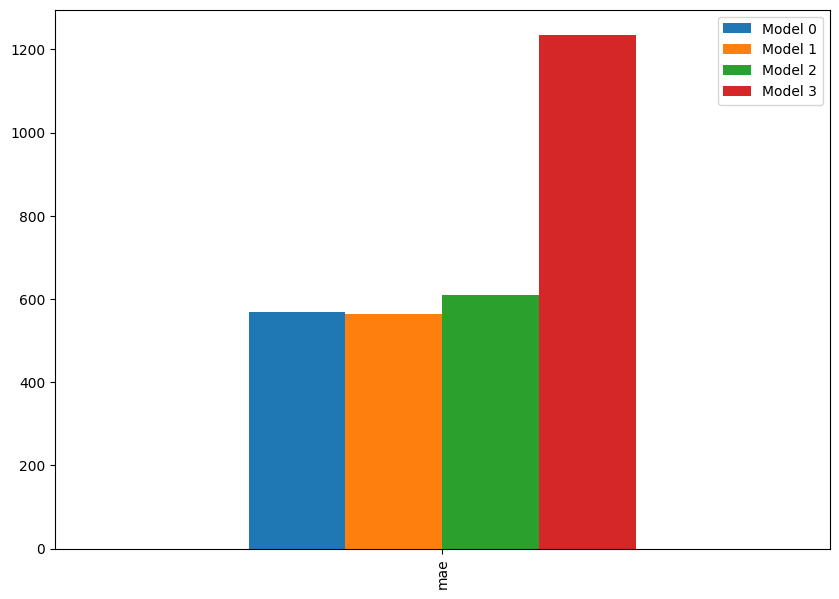

In [ ]:
model_compare1 = pd.DataFrame({'Model 0': model_0_metrics['Mean Absolute Error'],
                               'Model 1': model_1_metrics['Mean Absolute Error'],
                               'Model 2': model_2_metrics['Mean Absolute Error'],
                               'Model 3': model_3_metrics['Mean Absolute Error']}, index=['mae']).plot(figsize=(10, 7), kind='bar')

## Model 4 | Conv1D

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

train_windows, test_windows, train_labels, test_labels = train_test_split(full_windows, full_labels, shuffle=False, test_size=0.2)

In [ ]:
# Make Lambda layer to fit dimensions
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x : tf.expand_dims(x, axis=1))

In [ ]:
# Build
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x : tf.expand_dims(x, axis=1)),
    layers.Conv1D(128, 5, padding='causal', activation='relu'),
    layers.Dense(HORIZON)
], name='model_4_conv1d')

# Complile
model_4.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# Fit
history4 = model_4.fit(train_windows, train_labels,
                       validation_data=[test_windows, test_labels],
                       batch_size=128,
                       epochs=100,
                       callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
18/18 [==============================] - 2s 59ms/step - loss: 1141.7610 - mae: 1141.7610 - mse: 4690307.0000 - val_loss: 2601.3145 - val_mae: 2601.3145 - val_mse: 15223721.0000
Epoch 2/100
18/18 [==============================] - 1s 60ms/step - loss: 291.9826 - mae: 291.9826 - mse: 348964.3438 - val_loss: 1170.8772 - val_mae: 1170.8772 - val_mse: 3678153.0000
Epoch 3/100
18/18 [==============================] - 1s 62ms/step - loss: 177.8346 - mae: 177.8346 - mse: 156730.6875 - val_loss: 992.9044 - val_mae: 992.9044 - val_mse: 2971313.7500
Epoch 4/100
18/18 [==============================] - 1s 53ms/step - loss: 167.6984 - mae: 167.6984 - mse: 147041.2656 - val_loss: 929.9670 - val_mae: 929.9670 - val_mse: 2761647.0000
Epoch 5/100
18/18 [==============================] - 1s 40ms/step - loss: 161.8442 - mae: 161.8442 - mse: 138903.2656 - val_loss: 902.1894 - val_mae: 902.1894 - val_mse: 2659301.0000
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 158.

### Predictions

In [ ]:
model_4 = tf.keras.models.load_model('/content/model_experiments/model_4_conv1d')

model_4_preds = model_4.predict(test_windows)

18/18 [==============================] - 0s 2ms/step


In [ ]:
# Metrics
model_4_metrics = metrics_dict(test_labels, tf.squeeze(tf.cast(model_4_preds, dtype=tf.float64)))
model_4_metrics

{'Mean Absolute Error': 568.9783983540223,
 'Mean Absolute Percentage Error': 2.5455392678347883,
 'MSE': 1176618.0210367392,
 'RMSE': 1084.7202501275337,
 'MASE': 30.11810426461753}

### Plot model 4 predictions

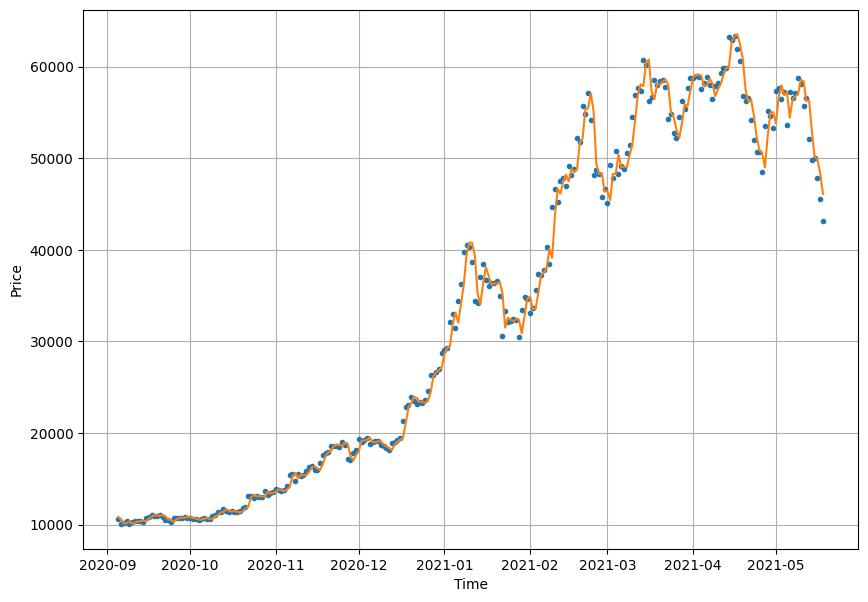

In [ ]:
offset = 300
plt.figure(figsize=(10,7))

plot_time_series(x=X_test[-len(test_windows):], y=test_labels[:, 0], start=offset, format='.', label='Test Data')
plot_time_series(x=X_test[-len(test_windows):], y=tf.squeeze(model_4_preds), start=offset, format='-', label='Test Data')

## Model 5 | LSTM

In [ ]:
# Build (using functional API)
inputs = tf.keras.Input(WINDOW_SIZE)
x = layers.Lambda(lambda x : tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name='model_5_lstm')

# Compile
model_5.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# Fit
history5 = model_5.fit(train_windows, train_labels,
                   validation_data=[test_windows, test_labels],
                   batch_size=32,
                   epochs=100,
                   callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
70/70 [==============================] - 4s 35ms/step - loss: 947.7385 - mae: 947.7385 - mse: 4731797.0000 - val_loss: 1013.9286 - val_mae: 1013.9286 - val_mse: 3144824.2500
Epoch 2/100
70/70 [==============================] - 3s 42ms/step - loss: 170.9741 - mae: 170.9741 - mse: 149457.6562 - val_loss: 940.4904 - val_mae: 940.4904 - val_mse: 2856507.0000
Epoch 3/100
70/70 [==============================] - 0s 5ms/step - loss: 162.6723 - mae: 162.6723 - mse: 141610.8906 - val_loss: 1021.7145 - val_mae: 1021.7145 - val_mse: 2997161.5000
Epoch 4/100
70/70 [==============================] - 2s 33ms/step - loss: 164.1074 - mae: 164.1074 - mse: 143242.0000 - val_loss: 864.7973 - val_mae: 864.7973 - val_mse: 2477642.0000
Epoch 5/100
70/70 [==============================] - 3s 47ms/step - loss: 155.4096 - mae: 155.4096 - mse: 130561.5078 - val_loss: 828.1134 - val_mae: 828.1134 - val_mse: 2314346.2500
Epoch 6/100
70/70 [==============================] - 1s 8ms/step - loss: 148.0667

### Predictions

In [ ]:
model_5 = tf.keras.models.load_model('/content/model_experiments/model_5_lstm')

model_5_preds = model_5.predict(test_windows)

18/18 [==============================] - 1s 5ms/step


In [ ]:
# Metrics
model_5_metrics = metrics_dict(test_labels, model_5_preds)
model_5_metrics

{'Mean Absolute Error': 565.1720734170467,
 'Mean Absolute Percentage Error': 2.5325473863209247,
 'MSE': 1158012.1932761737,
 'RMSE': 1076.109749642746,
 'MASE': 0.992850691009494}

### Plot model 5 predictions

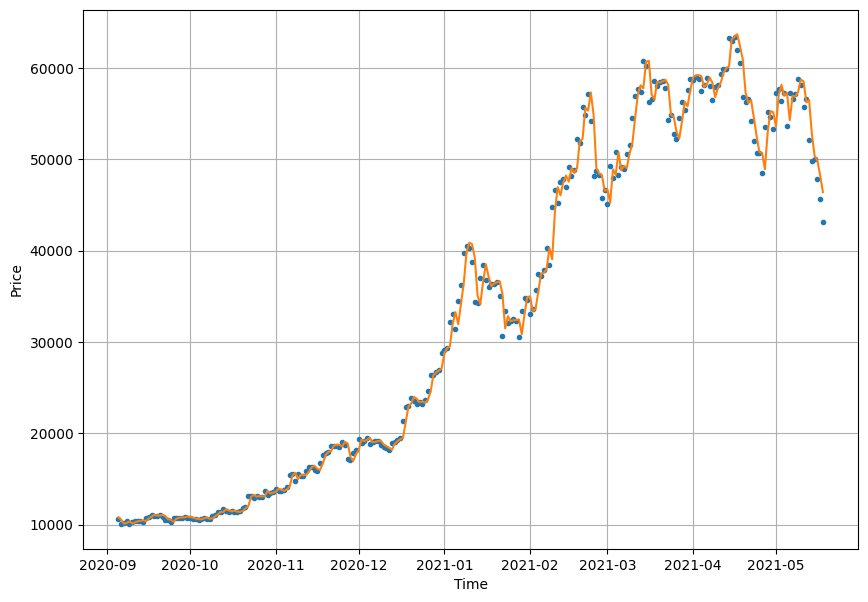

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))

plot_time_series(x=X_test[-len(test_windows):], y=test_labels[:, 0], start=offset, label='Test Data', format='.')
plot_time_series(x=X_test[-len(test_windows):], y=model_5_preds, start=offset, format='-', label='Test Data')

## Model 6 | Multivariate Series

### Making our multivariate time series dataset

We're using an open system: we can add any feature to our time series -> we're going to use the bitcoin block size halving events

In [ ]:
# Review dataset
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Block reward halving dataset
block_reward_1 = 50 # 3 January 2009
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64('2012-11-28')
block_reward_3_datetime = np.datetime64('2016-07-09')
block_reward_4_datetime = np.datetime64('2020-05-18')

In [ ]:
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = np.nan
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,NaN
2013-10-02,125.45500,NaN
2013-10-03,108.58483,NaN
2013-10-04,118.67466,NaN
2013-10-05,121.33866,NaN


In [ ]:
block_2_range = bitcoin_prices_block.loc[:'2016-07-09']
block_3_range = bitcoin_prices_block.loc['2016-07-10':'2020-05-18']
block_4_range = bitcoin_prices_block.loc['2020-05-19':]

In [ ]:
bitcoin_prices_block.loc[:'2016-07-09', 'block_reward'] = block_reward_2
bitcoin_prices_block.loc['2016-07-10':'2020-05-18', 'block_reward'] = block_reward_3
bitcoin_prices_block.loc['2020-05-19':, 'block_reward'] = block_reward_4

In [ ]:
bitcoin_prices_block.loc['2016-07-09':'2016-07-10']

,Price,block_reward
Date,,
2016-07-09,654.85299,25.0
2016-07-10,649.35600,12.5


<Axes: xlabel='Date'>

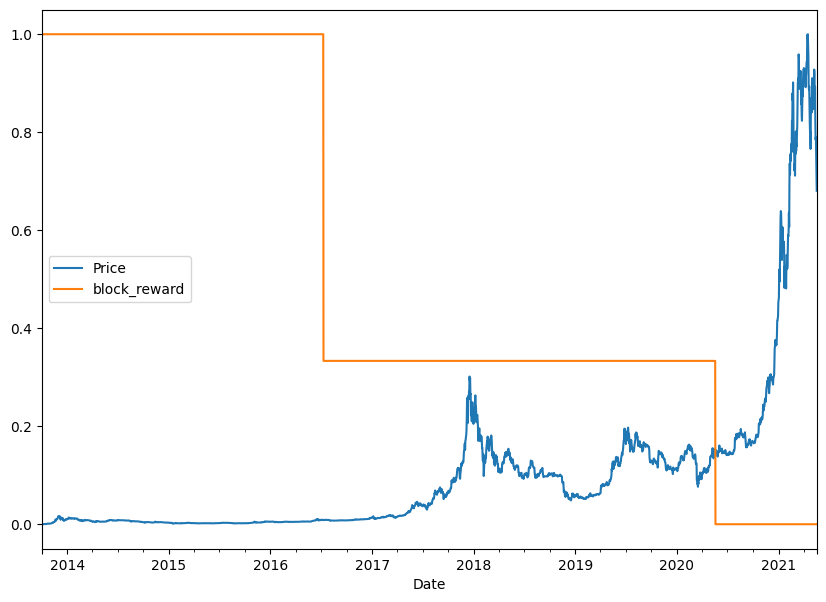

In [ ]:
# Plot block reward against price over time
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[['Price', 'block_reward']]),
                                                  columns=bitcoin_prices_block.columns,
                                                  index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7))

#### Making a windowed dataset with pandas

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price{i+1}"] = bitcoin_prices_windowed["Price"].shift(i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price1,Price2,Price3,Price4,Price5,Price6,Price7
Date,,,,,,,,,
2013-10-01,123.65499,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25.0,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25.0,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25.0,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25.0,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25.0,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25.0,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25.0,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25.0,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [ ]:
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype('float32')
y = bitcoin_prices_windowed.dropna()['Price'].astype('float32')
X.head()

,block_reward,Price1,Price2,Price3,Price4,Price5,Price6,Price7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
y.head()

,Price
Date,
2013-10-08,123.032997
2013-10-09,124.049004
2013-10-10,125.961159
2013-10-11,125.279663
2013-10-12,125.927498


In [ ]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

### The model

In [ ]:
# Build
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_6_multivariate')

# Compile
model_6.compile(loss='mae',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['mae', 'mse'])

# Fit
history6 = model_6.fit(X_train, y_train,
                       validation_data=[X_test, y_test],
                       epochs=100,
                       batch_size=128,
                       callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
18/18 [==============================] - 3s 94ms/step - loss: 1055.6735 - mae: 1055.6735 - mse: 4660236.5000 - val_loss: 1523.3638 - val_mae: 1523.3638 - val_mse: 5743832.5000
Epoch 2/100
18/18 [==============================] - 2s 97ms/step - loss: 252.9150 - mae: 252.9150 - mse: 266113.5000 - val_loss: 1356.2607 - val_mae: 1356.2607 - val_mse: 4752615.0000
Epoch 3/100
18/18 [==============================] - 2s 108ms/step - loss: 183.2247 - mae: 183.2247 - mse: 174316.8281 - val_loss: 912.4185 - val_mae: 912.4185 - val_mse: 2820125.0000
Epoch 4/100
18/18 [==============================] - 2s 129ms/step - loss: 157.6755 - mae: 157.6755 - mse: 134079.5625 - val_loss: 853.8911 - val_mae: 853.8911 - val_mse: 2442781.2500
Epoch 5/100
18/18 [==============================] - 2s 113ms/step - loss: 140.7604 - mae: 140.7604 - mse: 111516.2578 - val_loss: 743.0701 - val_mae: 743.0702 - val_mse: 1879111.8750
Epoch 6/100
18/18 [==============================] - 1s 46ms/step - loss: 1

### Predictions

In [ ]:
model_6 = tf.keras.models.load_model('/content/model_experiments/model_6_multivariate')

model_6_preds = model_6.predict(X_test)

18/18 [==============================] - 0s 1ms/step


In [ ]:
model_6_metrics = metrics_dict(tf.cast(y_test, dtype=tf.float32), tf.squeeze(model_6_preds))
model_6_metrics

{'Mean Absolute Error': 567.7225,
 'Mean Absolute Percentage Error': 2.5545941665768623,
 'MSE': 1160138.2,
 'RMSE': 1077.0972,
 'MASE': 0.99733126}

In [ ]:
model_0_metrics

{'Mean Absolute Error': 567.9802273457542,
 'Mean Absolute Percentage Error': 2.516524929982267,
 'MSE': 1147547.125023896,
 'RMSE': 1071.2362601330744,
 'MASE': 0.9995699939182624}

## Model 7 | N-BEATS Algorithm

#### Block Layer

In [ ]:
# Create NBEATSBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains a stack of 4 FC layers with ReLu activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]

    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta')

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)

    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

#### Test

In [ ]:
# Dummy NBeatsBlock Layer
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       horizon=HORIZON,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs -> same size as input_size
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Pass dummy inputs NBeatsBlock Layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

# These are the activation outputs of the theta layer ( they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.4894041   0.1281984  -0.03862458  0.32779557 -0.76665413 -0.5905345
 -0.31386605]
Forecast: 0.04751434177160263


### Prepare data

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create NBEATS data inputs -> univariate data
bitcoin_prices_nbeats = bitcoin_prices.copy()

for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Prices+{i+1}"] = bitcoin_prices_nbeats['Price'].shift(i+1)

bitcoin_prices_nbeats.head()

,Price,Prices+1,Prices+2,Prices+3,Prices+4,Prices+5,Prices+6,Prices+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Split data
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

In [ ]:
# Use tf.data API to make the dataset more performant
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetching
